### Look at first run results

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tqdm
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.constants import region_names, deg_string, gkg_string, region_points
from nemo_python_git.projects import testing, evaluation, overshoots
from nemo_python_git.plots import timeseries_by_region, timeseries_plot, circumpolar_plot, finished_plot
from nemo_python_git.plot_utils import set_colours
from matplotlib.lines import Line2D
import imageio
import glob
import cmocean

Check drift in near-bottom temperature and salinity by region:

Processing amundsen_sea
Processing bellingshausen_sea
Processing larsen
Processing filchner_ronne
Processing east_antarctica
Processing amery
Processing ross


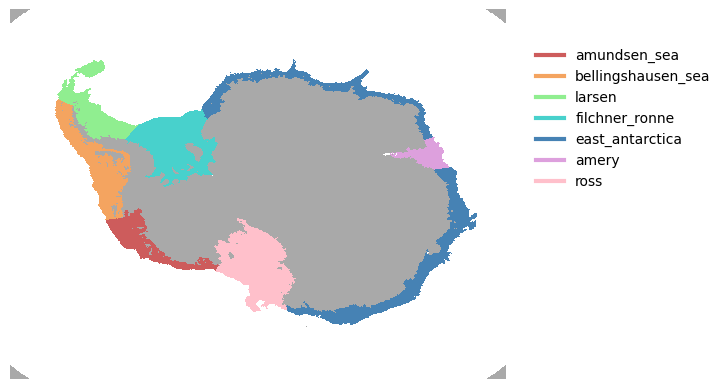

In [2]:
testing.plot_region_map(file_path='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240123-filledlakes.nc', 
                        option='all', fig_name=None, halo=False, legend=True)

In [2]:
# load regions file
regions_file = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_all.nc')

# load timeseries
ts = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/timeseries.nc')

In [3]:
regions   = ['amundsen_sea', 'bellingshausen_sea', 'larsen', 'filchner_ronne', 'amery', 'ross', 'all']
colours   = ['IndianRed', 'SandyBrown', 'LightGreen', 'MediumTurquoise', 'Plum', 'Pink', 'gray']
var_names = ['bwtemp', 'bwsalt', 'cavity_temp', 'cavity_salt', 'shelf_temp', 'shelf_salt', 'draft']

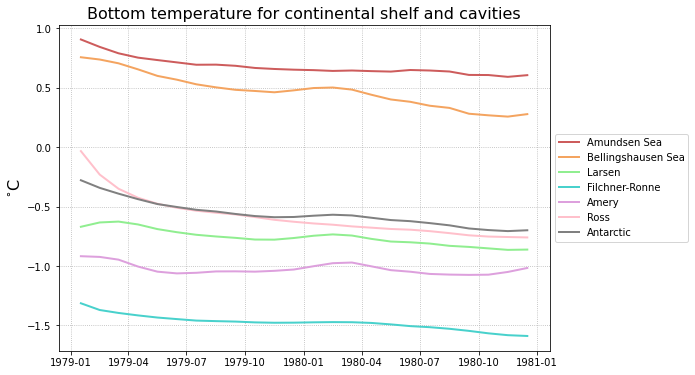

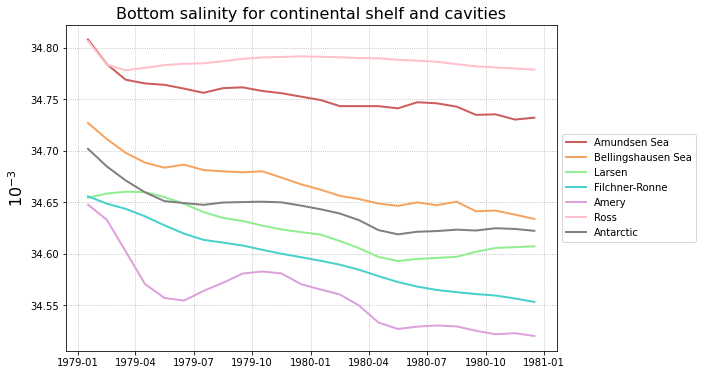

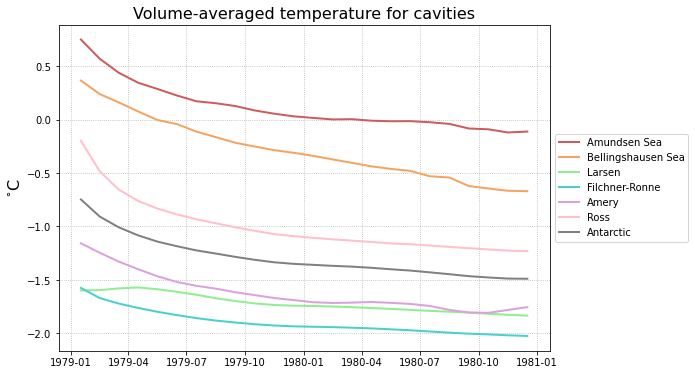

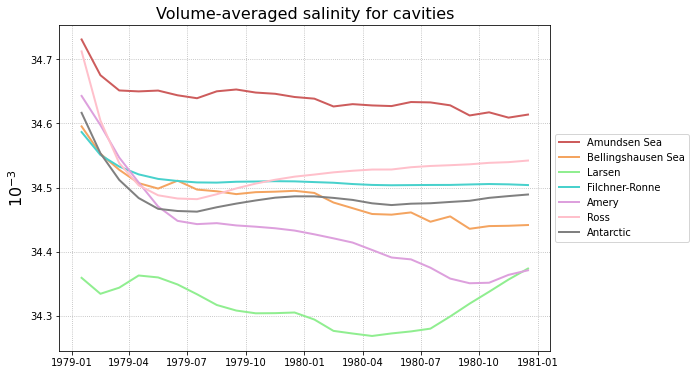

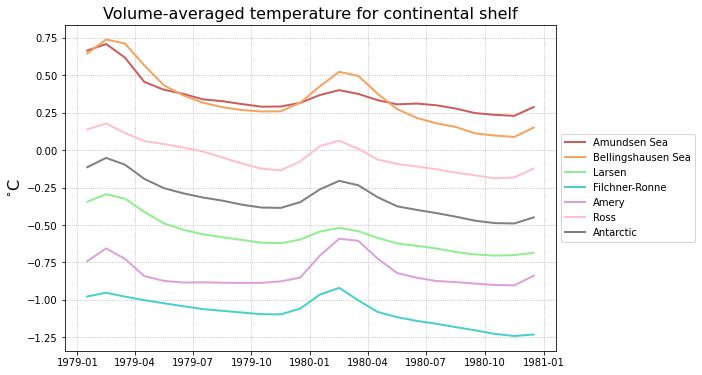

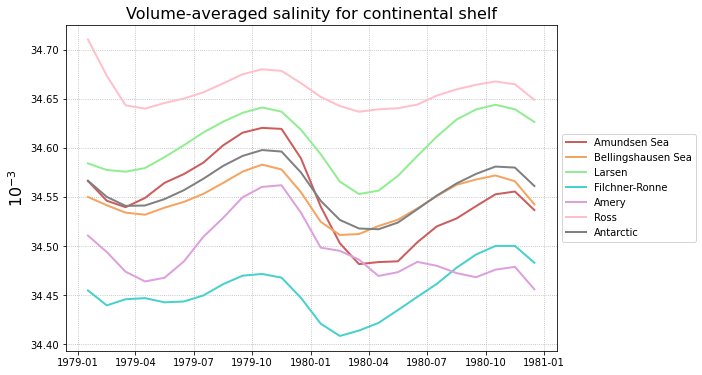

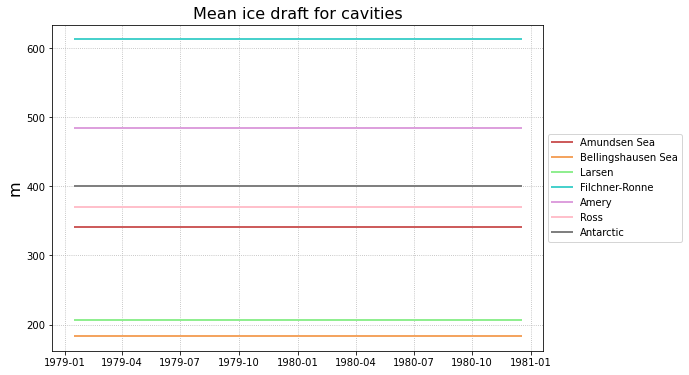

In [4]:
for var in var_names:
    timeseries_by_region(var, '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980',
                         regions=regions, colours=colours, timeseries_file='timeseries.nc', smooth=0, fig_name=None, linewidth=2)

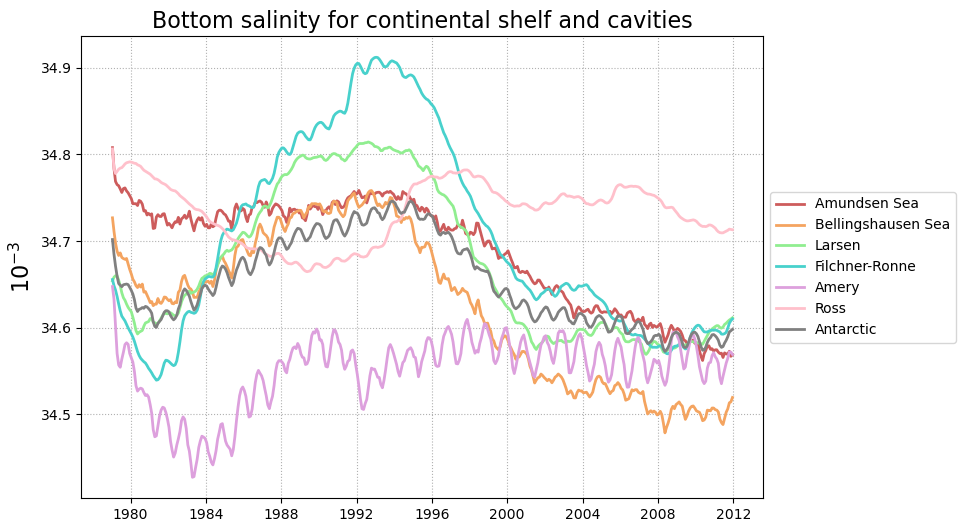

In [4]:
timeseries_by_region('bwsalt', '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980',
                     regions=regions, colours=colours, timeseries_file='timeseries-backup.nc', smooth=0, fig_name=None, linewidth=2)

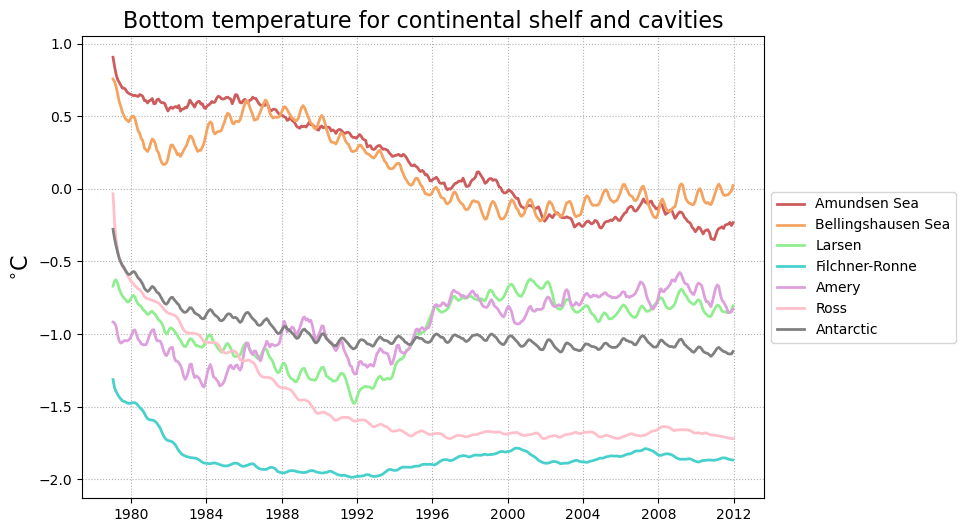

In [5]:
timeseries_by_region('bwtemp', '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980',
                     regions=regions, colours=colours, timeseries_file='timeseries-backup.nc', smooth=0, fig_name=None, linewidth=2)

Also look at:
- SSH drift in full domain
- T, S thermocline drift

In [3]:
# Calculate TS profiles:
run_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'
nemo_mesh  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240123-filledlakes.nc')

In [10]:
profiles = xr.open_dataset(f'{run_folder}timeseries-profiles.nc')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


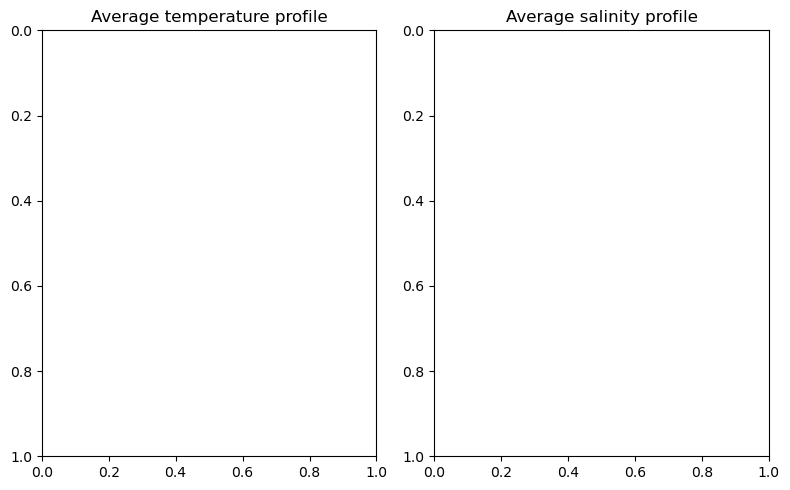

In [67]:
fig, ax = plt.subplots(1,2, figsize=(8,5))

for i, name in enumerate(['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross','amery','all']):
    profiles[f'thetao_profile_{name}'].plot(ax=ax[0], color=colours[i], linewidth=0.5)
    profiles[f'so_profile_{name}'].plot(ax=ax[1], color=colours[i], linewidth=0.5)

for axis in ax.ravel():
    axis.invert_yaxis()

ax[0].set_title('Average temperature profile')
ax[1].set_title('Average salinity profile')

custom_lines=[]
for colour in colours:
    custom_lines = custom_lines + [Line2D([0], [0], color=colour, lw=3)]
    ax[1].legend(custom_lines, regions, frameon=False, loc=(1.05, 0.5))
    
fig.tight_layout()
# ax[1].plot(ts_amundsen_bwalt)

In [8]:
year=1979
df = xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')

In [ ]:
var   = 'mldr10_1' #'siconc'
for year in range(1996,2013):
    ds = xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')
    for month in range(1,13):
        fig, ax = plt.subplots(1,1, figsize=(10,8))
        circumpolar_plot(ds[var].isel(time_counter=month-1), nemo_mesh.isel(time_counter=0), ax=ax,
                         make_cbar=True, return_fig=False, ctype='viridis', lat_max=-50, vmin=0, vmax=400, title=f'{var} {year}-{month:02}')
        fig.tight_layout()
        finished_plot(fig, fig_name=f'{run_folder}temp/{var}-y{year}m{month:02}.jpg')
        plt.close()

In [6]:
filenames=np.sort(glob.glob(f'{run_folder}temp/{var}-y????m??.jpg'))
create_animation(filenames, out_file=f'{run_folder}circumpolar-{var}.mp4')

/tmp/ipykernel_5823/713629286.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 800) to (1008, 800) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6ccfd00] Warning: data is not aligned! This can lead to a speed loss


Create file containing region masks

In [7]:
def create_regions_file(nemo_mesh, option, out_file):

    ds = xr.Dataset(
        coords={'nav_lon':(["y","x"], nemo_mesh.nav_lon.values),
                'nav_lat':(["y","x"], nemo_mesh.nav_lat.values)})
    
    masks={}
    # later should be for name in region_names
    for name in ['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross', 'amery', 'all']: 
        mask, _, region_name = region_mask(name, nemo_mesh, option=option, return_name=True) 
        masks[name] = mask 
        ds = ds.assign({f'mask_{name}':(["y","x"], masks[name].values)})   
    
    ds.to_netcdf(out_file)
    
    return ds

In [ ]:
create_regions_file(nemo_mesh, 'all'   , '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_all.nc')
create_regions_file(nemo_mesh, 'shelf' , '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_shelf.nc')
create_regions_file(nemo_mesh, 'cavity', '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_cavity.nc')

# Animations etc.

In [5]:
# To make circular maps:
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

NameError: name 'mpath' is not defined

In [4]:
def prepare_plot(figsize=(15, 8)):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    fig, ax = plt.subplots(1,2, figsize=figsize, subplot_kw={'projection': ccrs.SouthPolarStereo()})
    for axis in ax.ravel():
        axis.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        axis.set_boundary(map_circle, transform=axis.transAxes)
        # ax.coastlines(); 
        gl = axis.gridlines(draw_labels=True, ylocs=[]);#, color='w', lw=2);
    return fig, ax

In [5]:
# tmask = np.ma.masked_where(mesh.tmask.values==0, mesh.tmask.values)

In [14]:
def plot_2D_circumpolar(fileT, month, depth, path='.', save=True, Tmin=-4, Tmax=4):

    kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True, 'vmin':Tmin, 'vmax':Tmax}
    kwags2  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.haline, 'rasterized':True, 'vmin':33, 'vmax':35.5}
    fig, ax = prepare_plot()
    cm1 = ax[0].pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.thetao.isel(time_counter=month-1, deptht=depth), **kwags1)
    ax[0].add_feature(cfeature.LAND, color='w', zorder=3)
    cm2 = ax[1].pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.so.isel(time_counter=month-1, deptht=depth), **kwags2)
    ax[1].add_feature(cfeature.LAND, color='w', zorder=3)
    CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04)
    CB1.set_label(fileT.thetao.long_name)
    CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04)
    CB2.set_label(fileT.so.long_name)

    date = fileT.time_counter.isel(time_counter=month-1).dt.strftime('%Y-%m').values
    year = str(date)[:-3]
    fig.suptitle(f"{str(date)}, depth: {mesh.nav_lev.values[depth]:.1f} m")
    
    if save:
        fig.savefig(f'{path}circumpolar_y{year}m{month:02}z{depth:03}.jpg', bbox_inches='tight')

    plt.close(fig)
    
    return

In [5]:
def create_animation(filenames, out_file='test.mp4'):
    
    # filenames is a list of the names/locations of image files to combine into animation (mp4 in this case)
    with imageio.get_writer(f'{out_file}', fps=2, mode='I') as writer: 
        for filename in filenames:  
            image = imageio.imread(filename)  
            writer.append_data(image)
    return

In [20]:
def amundsen_frame(fileT_ini, var, month, path):
    depth_ind = [0, 18, 35]
    fileT    = fileT_ini.isel(x_grid_T=slice(500, 900), y_grid_T=slice(150,350))
    mesh_sub = mesh.isel(x=slice(500, 900), y=slice(150,350))
    
    # --------- figure -------------------------------------------------------------
    fig  = plt.figure(figsize=(18,8))
    date = fileT_ini.time_counter.isel(time_counter=month-1).dt.strftime('%Y-%m').values
    fig.suptitle(f"{str(date)}")
    gs = fig.add_gridspec(3,5)
    
    ax1 = fig.add_subplot(gs[0, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
    ax2 = fig.add_subplot(gs[1, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
    ax3 = fig.add_subplot(gs[2, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
    ax4 = fig.add_subplot(gs[:, 3]) # temperature
    ax5 = fig.add_subplot(gs[:, 4]) # salinity
    
    vm = [(-2.5, 2.5),(-2.5,2.5),(-2.5,2.5)] # colorbar limits
    # vm = [(31, 34.5),(31,34.5),(34.4,35)] # colorbar limits
    # Coordinates of 'stations'
    i1, i2 = (249, 715) # on Amundsen shelf
    s1, s2 = (271, 711) # Amundsen shelf break
    o1, o2 = (281, 711) # off Amundsen slope
    lon    = mesh.nav_lon.values
    lat    = mesh.nav_lat.values
    
    # --- Maps ---
    kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True}
    for i, axis in enumerate([ax1, ax2, ax3]):
        axis.set_extent([-80, -140, -75.5, -68], ccrs.PlateCarree())
        axis.set_title(f'{fileT[var].long_name}, depth: {mesh.nav_lev.values[depth_ind[i]]:.1f} m')
        lon_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT.nav_lon_grid_T.values)
        lat_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT.nav_lat_grid_T.values)
        plot_var = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT[var].isel(time_counter=month-1, deptht=depth_ind[i]).values)
        cm = axis.pcolormesh(lon_plot, lat_plot, plot_var, vmin=vm[i][0], vmax=vm[i][1], **kwags1)
    
        # mark shelf break with dashed line
        axis.contour(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, mesh_sub.bathy_metry, [1200], 
                     linestyles='--', linewidths=0.8, colors='k', transform=ccrs.PlateCarree(), zorder=3)
    
        stn_kwags = {'transform':ccrs.PlateCarree(), 'marker':'*', 's':90, 'zorder':3, 'edgecolors':'k', 'linewidths':0.6}
        axis.scatter([lon[i1,i2], lon[i1,i2]], [lat[i1,i2], lat[i1,i2]], **stn_kwags)
        axis.scatter([lon[s1,s2], lon[s1,s2]], [lat[s1,s2], lat[s1,s2]], **stn_kwags)
        axis.scatter([lon[o1,o2], lon[o1,o2]], [lat[o1,o2], lat[o1,o2]], **stn_kwags)
        CB1 = fig.colorbar(cm, ax=axis, fraction=0.04)

        gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False; gl.right_labels = False;
        gl.xlines = False; gl.ylines = False;
        
    # --- profiles ---
    ax4.set_xlim(-2.5, 2.5)
    ax5.set_xlim(32.5, 35)
    vars = ['thetao', 'so']
    for i, axis in enumerate([ax4, ax5]):
        axis.invert_yaxis()
        axis.set_ylim(600, 0)
        plot1 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=i1, x_grid_T=i2) == 0, np.nan, 
                         fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=i1, x_grid_T=i2))
        plot2 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=s1, x_grid_T=s2) == 0, np.nan, 
                         fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=s1, x_grid_T=s2))
        plot3 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=o1, x_grid_T=o2) == 0, np.nan, 
                         fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=o1, x_grid_T=o2))
        axis.set_title(fileT_ini[vars[i]].long_name)
        axis.plot(plot1, mesh.nav_lev, label='Shelf')
        axis.plot(plot2, mesh.nav_lev, label='Shelf break')
        axis.plot(plot3, mesh.nav_lev, label='Open ocean')
        
        for di in depth_ind:
            axis.plot([-10, 40],[mesh.nav_lev.values[di], mesh.nav_lev.values[di]], '--k')
        axis.set_ylabel('Depth (m)')
        axis.legend(frameon=False, loc=(0.1, 0.05), fontsize=12)
    
    fig.tight_layout()
    fig.savefig(f'{path}amundsen_{var}_y{str(date)[:-3]}m{month:02}.jpg', bbox_inches='tight')
    plt.close(fig)
    return

In [17]:
mesh = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240201.nc').isel(time_counter=0)

In [21]:
var='so'

run_path  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'
for year in range(1979,2011):
    fileT = xr.open_dataset(run_path + f'eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')
    for month in range(1,13):
        amundsen_frame(fileT, var, month, run_path+'temp/')

# filenames=glob.glob(f'{run_path}temp/amundsen_{var}_y????m??.jpg')

# create_animation(filenames, out_file=f'{run_path}amundsen-so.mp4')

In [ ]:
run_path = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'

for year in range(1979,1988):
    fileT = xr.open_dataset(run_path + f'eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')
    for depth in [0, 20, 50]:
        for month in range(1,13):
            plot_2D_circumpolar(fileT, month, depth, path=run_path+'temp/')

for depth in [0, 20, 50]:
    filenames=glob.glob(f'{run_path}temp/circumpolar_y????m??z{depth:03}.jpg')        
    create_animation(filenames, out_file=f'{run_path}circumpolar_monthly_z{depth:03}.mp4')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(18,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

for axis in ax.ravel():
    axis.set_extent([-90, -160, -78, -64], ccrs.PlateCarree())
    cs = axis.contour(SOSE_sal_jan.XC, SOSE_sal_jan.YC, SOSE_sal_jan.Depth, levels=[1000, 2000], 
                      colors='w', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    
cm1 = ax[0,0].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_an.isel(time=0), 
                             transform=ccrs.PlateCarree(), vmin=31, vmax=34)
# CB1 = fig.colorbar(cm1, ax=ax[0,0], fraction=0.03, label='Sea water salinity at standard depths (g/kg)')